# De Telegraaf Scraper Results Analysis

This notebook provides comprehensive analysis of the scraped data from De Telegraaf using the keyword search functionality.

## Project Overview
- **Source**: De Telegraaf (telegraaf.nl)
- **Date Range**: October 7, 2023 - August 8, 2025
- **Search Method**: MediaCloud API


## Data Structure
Each article contains:
- `id`: Unique article identifier
- `title`: Article headline
- `url`: Article URL
- `publish_date`: Publication date
- `language`: Article language (Dutch)
- `media_name`: Source publication
- `found_keyword`: Search keyword that matched
- `search_timestamp`: When the search was performed

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import glob
import os
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Data Loading and Preprocessing

In [8]:
# Load all JSON files from data directory
def load_all_data():
    # Update the path to reflect Google Drive mounting
    data_files = glob.glob('/content/drive/My Drive/notebook/data/telegraaf_*.json')
    all_articles = []
    file_stats = {}

    print(f"Found {len(data_files)} data files")

    for file_path in data_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if data:  # Skip empty files
                    filename = os.path.basename(file_path)
                    # Extract keyword from filename
                    # Assuming filename format is telegraaf_keyword_timestamp.json
                    parts = filename.replace('telegraaf_', '').split('_')
                    if len(parts) > 1:
                        keyword = parts[0]
                    else:
                        # Fallback if filename format is unexpected
                        keyword = 'unknown_keyword'


                    # Add keyword to each article if not present
                    for article in data:
                        if 'found_keyword' not in article:
                            article['found_keyword'] = keyword

                    all_articles.extend(data)
                    file_stats[keyword] = file_stats.get(keyword, 0) + len(data) # Aggregate counts for the same keyword across files
                    print(f"Loaded {len(data)} articles for keyword: {keyword} from {filename}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    print(f"\nTotal articles loaded: {len(all_articles)}")
    return all_articles, file_stats

articles_data, keyword_counts = load_all_data()

Found 32 data files
Loaded 33 articles for keyword: islamofobie from telegraaf_islamofobie_20250812_101142.json
Loaded 178 articles for keyword: idf from telegraaf_idf_20250812_102508.json
Loaded 47 articles for keyword: zionisme from telegraaf_zionisme_20250812_103534.json
Loaded 1 articles for keyword: anti-moslim from telegraaf_anti-moslim_20250812_101446.json
Loaded 3 articles for keyword: zionistisch from telegraaf_zionistisch_20250812_103738.json
Loaded 51 articles for keyword: west bank from telegraaf_west bank_20250812_102405.json
Loaded 6719 articles for keyword: israël from telegraaf_israël_20250812_103016.json
Loaded 4 articles for keyword: israel defence forces from telegraaf_israel defence forces_20250812_102712.json
Loaded 2699 articles for keyword: hamas from telegraaf_hamas_20250812_102059.json
Loaded 368 articles for keyword: palestina from telegraaf_palestina_20250812_101547.json
Loaded 46 articles for keyword: antisemitisch from telegraaf_antisemitisch_20250812_100

In [9]:
# Convert to DataFrame
df = pd.DataFrame(articles_data)

# Data preprocessing
if not df.empty:
    # Convert date columns
    if 'publish_date' in df.columns:
        df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')

    if 'indexed_date' in df.columns:
        df['indexed_date'] = pd.to_datetime(df['indexed_date'], errors='coerce')

    # Extract year and month for analysis
    df['year'] = df['publish_date'].dt.year
    df['month'] = df['publish_date'].dt.month
    df['year_month'] = df['publish_date'].dt.to_period('M')

    # Clean and categorize keywords
    df['keyword_category'] = df['found_keyword'].apply(lambda x:
        'antisemitism' if any(term in str(x).lower() for term in ['antisemit', 'anti-semit']) else
        'islamophobia' if any(term in str(x).lower() for term in ['islamofob', 'anti-moslim']) else
        'israel_palestine' if any(term in str(x).lower() for term in ['israel', 'palestin', 'gaza', 'west bank']) else
        'militant_groups' if any(term in str(x).lower() for term in ['hamas', 'hezbollah', 'hizbollah', 'idf']) else
        'zionism' if any(term in str(x).lower() for term in ['zion']) else
        'genocide' if any(term in str(x).lower() for term in ['genocid', 'genocide']) else
        'other'
    )

print(f"DataFrame shape: {df.shape}")
print(f"Date range: {df['publish_date'].min()} to {df['publish_date'].max()}")
print(f"Unique keywords: {df['found_keyword'].nunique()}")
df.head()

DataFrame shape: (15593, 15)
Date range: 2024-03-04 00:00:00 to 2025-08-08 00:00:00
Unique keywords: 24


,id,indexed_date,language,media_name,media_url,publish_date,title,url,found_keyword,search_timestamp,source_id,year,month,year_month,keyword_category
0,3e26e735052a313ece19d37efa636cb1dc35c2e1e69cd2...,2025-04-30 04:30:24.753174+00:00,nl,telegraaf.nl,telegraaf.nl,2025-04-30,"NAVO-eis slaat gat in begroting, kabinet staat...",https://www.telegraaf.nl/nieuws/33885417/navo-...,islamofobie,20250812_101142,41750,2025,4,2025-04,islamophobia
1,a8692bd93dc74e8fa0b9401e43009ded8821aaf2156fd7...,2025-04-29 23:20:50.427956+00:00,nl,telegraaf.nl,telegraaf.nl,2025-04-29,"Dode gevonden in woning Arnhem, verdachte aang...",https://www.telegraaf.nl/nieuws/11908863/dode-...,islamofobie,20250812_101142,41750,2025,4,2025-04,islamophobia
2,89820924a158239518697d0105a6b122f30545cdf44907...,2025-04-29 21:36:29.370985+00:00,nl,telegraaf.nl,telegraaf.nl,2025-04-29,Nausicaa Marbe uit kritiek op opmerking over i...,https://www.telegraaf.nl/video/1190862295/naus...,islamofobie,20250812_101142,41750,2025,4,2025-04,islamophobia
3,3cf21ad4412282ec01455bef13b9807ba83b2c958545b7...,2025-03-28 19:31:37.496291+00:00,nl,telegraaf.nl,telegraaf.nl,2025-03-28,"Hamas-terroristen worden dagelijks vereerd, te...",https://www.telegraaf.nl/nieuws/1693624290/ham...,islamofobie,20250812_101142,41750,2025,3,2025-03,islamophobia
4,9be92b0c09c14f984f9dc8134bceca21be1f3458fd6d42...,2025-03-20 14:32:57.880108+00:00,nl,telegraaf.nl,telegraaf.nl,2025-03-20,Met deze creatieve oplossing wordt het makkeli...,https://www.telegraaf.nl/nieuws/1884723489/met...,islamofobie,20250812_101142,41750,2025,3,2025-03,islamophobia


## Summary Statistics

In [21]:
# Basic statistics table
print("=== DATASET OVERVIEW ===")
print(f"Total Articles: {len(df):,}")
print(f"Unique Keywords: {df['found_keyword'].nunique()}")
print(f"Date Range: {df['publish_date'].min().strftime('%Y-%m-%d')} to {df['publish_date'].max().strftime('%Y-%m-%d')}")
print(f"Languages: {df['language'].value_counts().to_dict()}")

# Keyword distribution table
keyword_stats = df.groupby('found_keyword').agg({
    'id': 'count',
    'publish_date': ['min', 'max']
}).round(2)
keyword_stats.columns = ['Article_Count', 'First_Article', 'Last_Article']
keyword_stats = keyword_stats.sort_values('Article_Count', ascending=False)

print("\n=== KEYWORD STATISTICS ===")
print(keyword_stats.head(24))

=== DATASET OVERVIEW ===
Total Articles: 15,593
Unique Keywords: 24
Date Range: 2024-03-04 to 2025-08-08
Languages: {'nl': 15593}

=== KEYWORD STATISTICS ===
                         Article_Count First_Article Last_Article
found_keyword                                                    
israël                            6719    2024-03-04   2025-08-08
hamas                             2699    2024-03-04   2025-08-08
gaza                              2402    2024-03-08   2025-08-08
hezbollah                         1244    2024-03-04   2025-08-08
israel                             549    2024-03-06   2025-08-08
antisemitisme                      472    2024-03-21   2025-08-01
palestina                          368    2024-03-18   2025-08-07
israëlisch                         336    2024-03-27   2025-08-08
westelijke jordaanoever            212    2024-04-09   2025-07-31
idf                                178    2024-03-24   2025-08-08
genocide                           120    2024-03-

In [11]:
# Category distribution table
category_stats = df.groupby('keyword_category').agg({
    'id': 'count',
    'found_keyword': 'nunique'
}).round(2)
category_stats.columns = ['Total_Articles', 'Unique_Keywords']
category_stats['Percentage'] = (category_stats['Total_Articles'] / len(df) * 100).round(1)
category_stats = category_stats.sort_values('Total_Articles', ascending=False)

print("\n=== CATEGORY STATISTICS ===")
print(category_stats)


=== CATEGORY STATISTICS ===
                  Total_Articles  Unique_Keywords  Percentage
keyword_category                                             
other                       7300                5        46.8
militant_groups             4121                3        26.4
israel_palestine            3444                7        22.1
antisemitism                 519                3         3.3
genocide                     120                1         0.8
zionism                       55                3         0.4
islamophobia                  34                2         0.2


## Visualizations

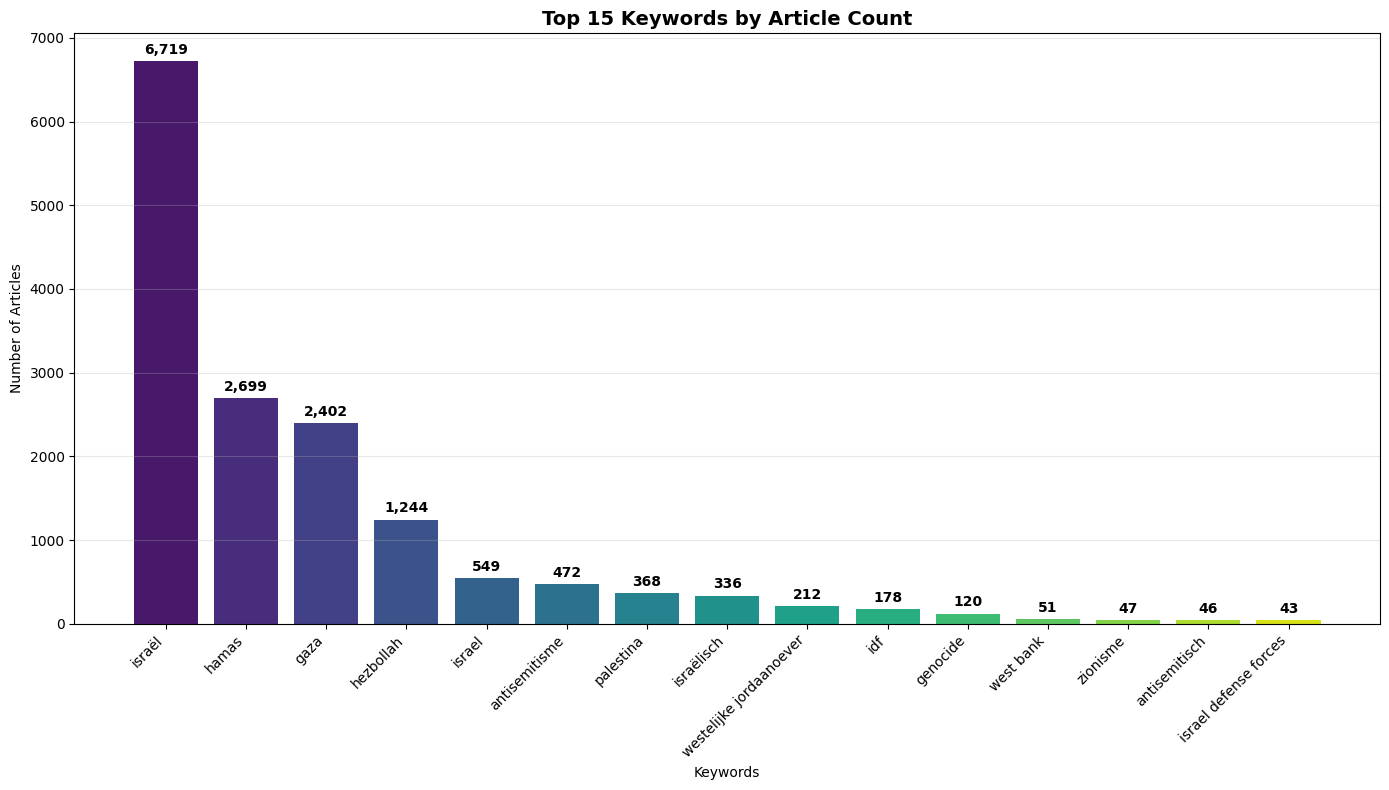

In [12]:
# 1. Article Count by Keyword (Top 15)
plt.figure(figsize=(14, 8))
top_keywords = df['found_keyword'].value_counts().head(15)

bars = plt.bar(range(len(top_keywords)), top_keywords.values,
               color=sns.color_palette("viridis", len(top_keywords)))
plt.xlabel('Keywords')
plt.ylabel('Number of Articles')
plt.title('Top 15 Keywords by Article Count', fontsize=14, fontweight='bold')
plt.xticks(range(len(top_keywords)), top_keywords.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height()):,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

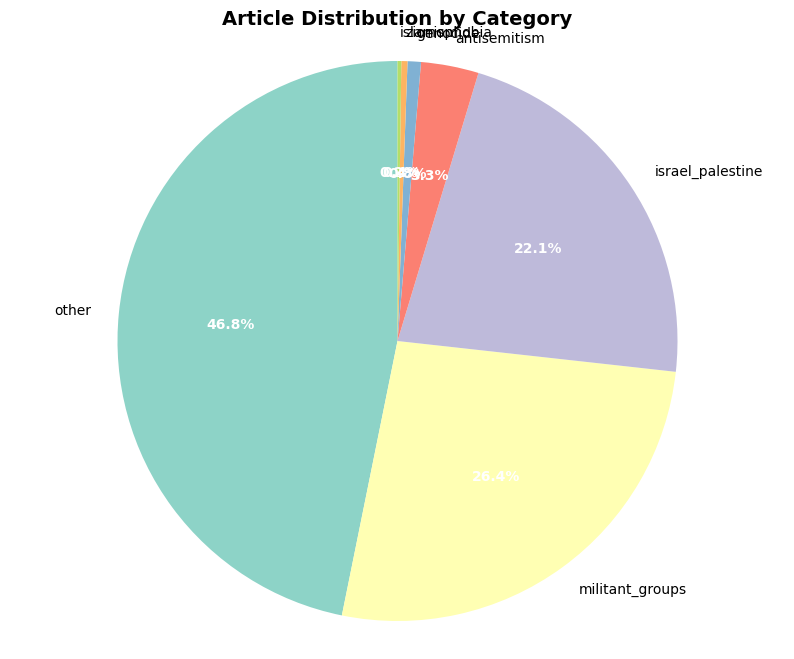

In [13]:
# 2. Category Distribution Pie Chart
plt.figure(figsize=(10, 8))
category_counts = df['keyword_category'].value_counts()

colors = sns.color_palette("Set3", len(category_counts))
wedges, texts, autotexts = plt.pie(category_counts.values, labels=category_counts.index,
                                  autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Article Distribution by Category', fontsize=14, fontweight='bold')

# Enhance text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.axis('equal')
plt.show()

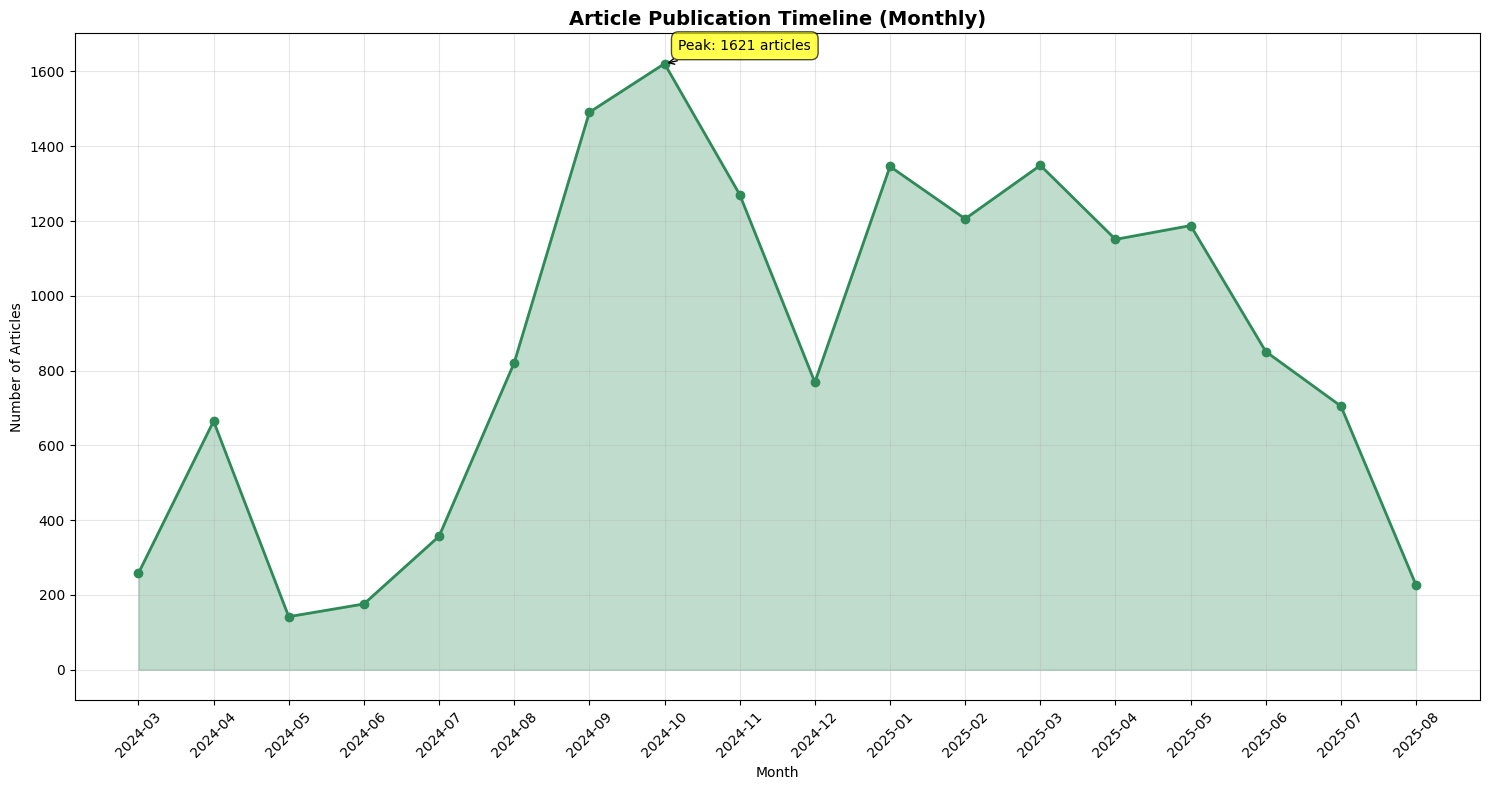

In [14]:
# 3. Articles Over Time (Monthly)
plt.figure(figsize=(15, 8))
monthly_counts = df.groupby(df['publish_date'].dt.to_period('M')).size()

plt.plot(monthly_counts.index.astype(str), monthly_counts.values,
         marker='o', linewidth=2, markersize=6, color='#2E8B57')
plt.fill_between(monthly_counts.index.astype(str), monthly_counts.values, alpha=0.3, color='#2E8B57')

plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.title('Article Publication Timeline (Monthly)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add annotations for peaks
max_month = monthly_counts.idxmax()
max_count = monthly_counts.max()
plt.annotate(f'Peak: {max_count} articles',
             xy=(str(max_month), max_count),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

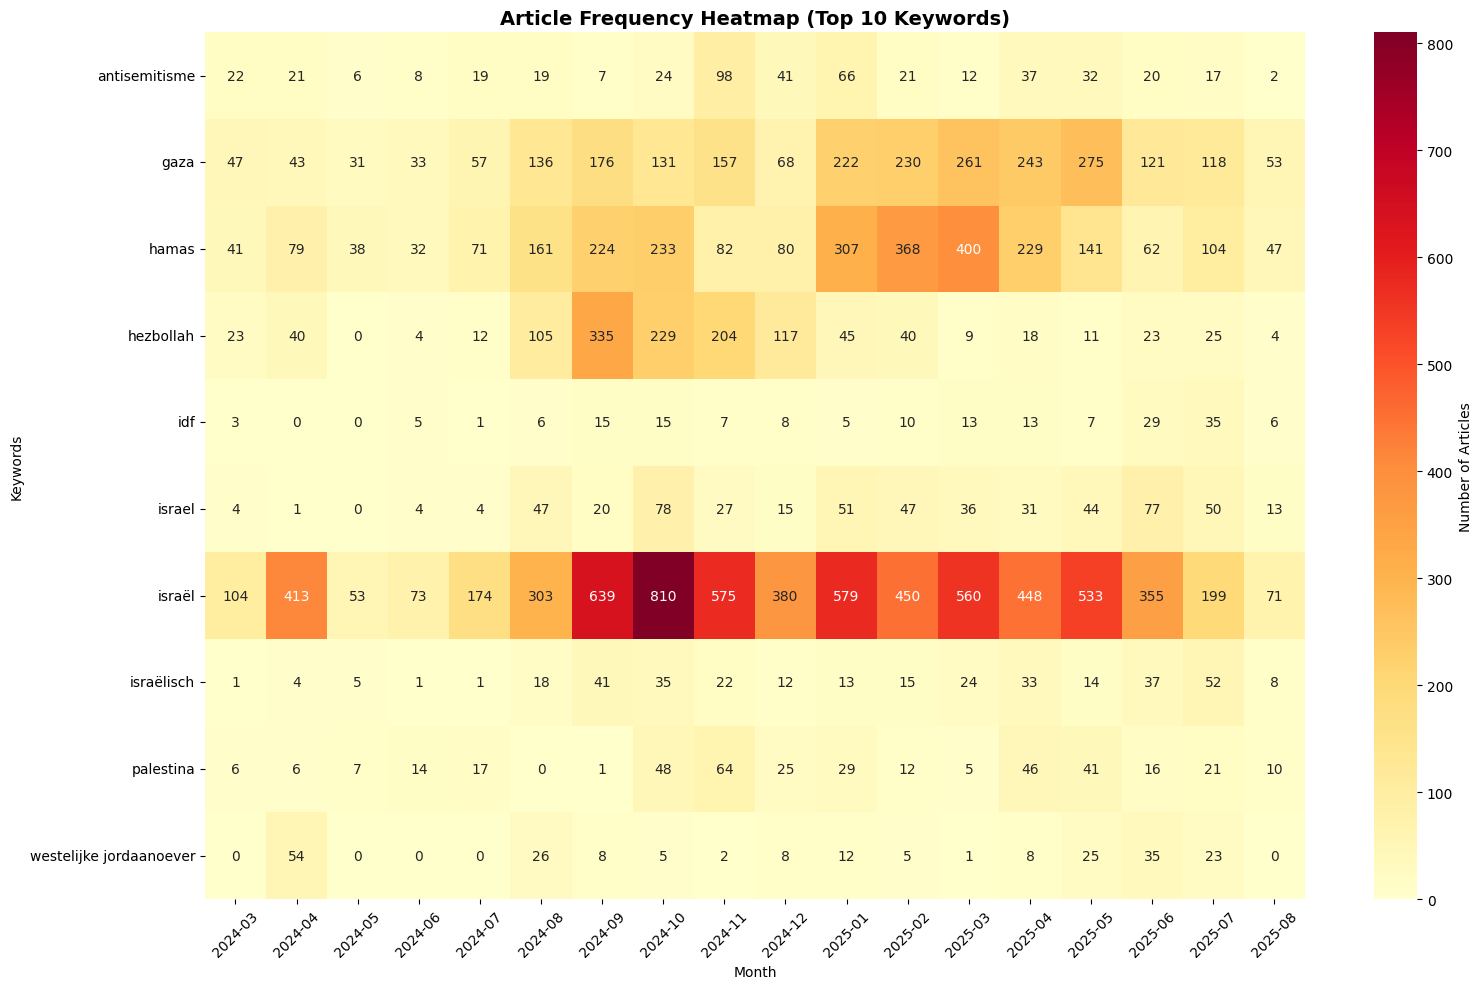

In [15]:
# 4. Heatmap of Keywords by Month
plt.figure(figsize=(16, 10))

# Select top 10 keywords for better visibility
top_10_keywords = df['found_keyword'].value_counts().head(10).index
df_filtered = df[df['found_keyword'].isin(top_10_keywords)]

# Create pivot table
heatmap_data = df_filtered.pivot_table(
    index='found_keyword',
    columns='year_month',
    values='id',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd',
            cbar_kws={'label': 'Number of Articles'})
plt.title('Article Frequency Heatmap (Top 10 Keywords)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Keywords')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

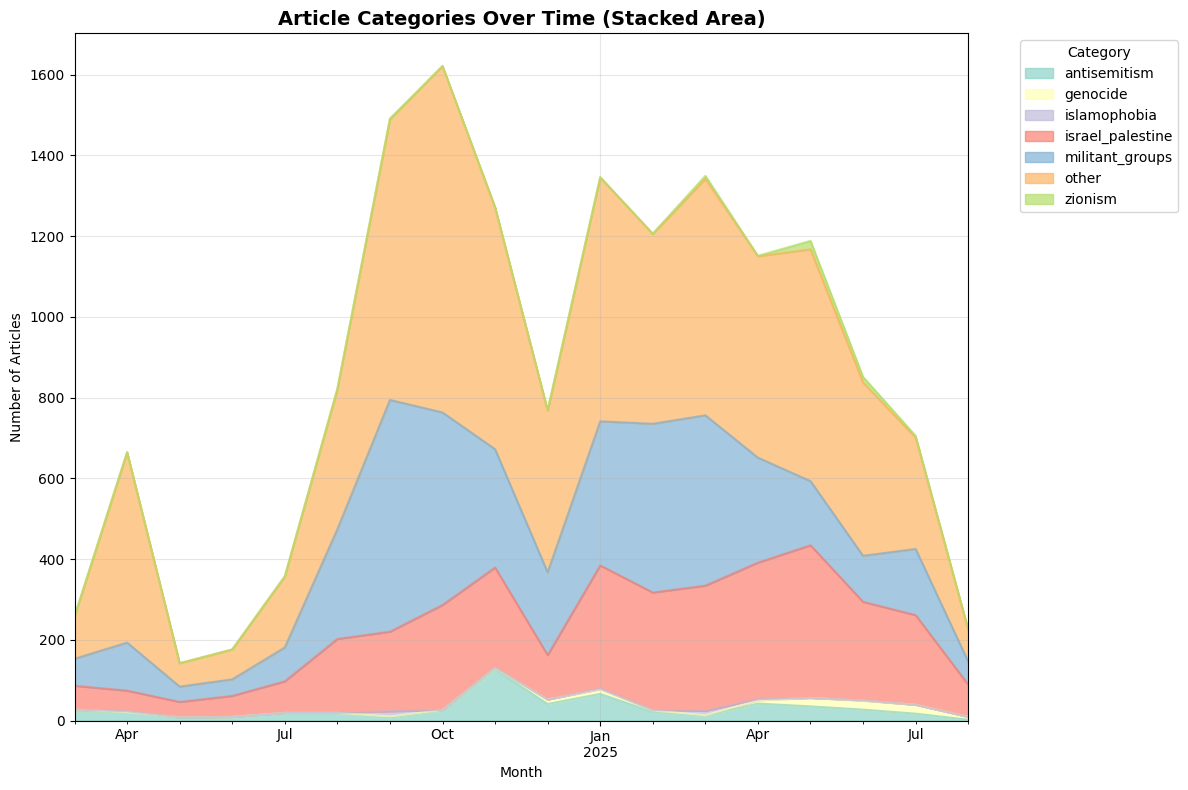

In [16]:
# 5. Category Distribution Over Time
plt.figure(figsize=(15, 8))

category_monthly = df.groupby(['year_month', 'keyword_category']).size().unstack(fill_value=0)

category_monthly.plot(kind='area', stacked=True, alpha=0.7,
                      color=sns.color_palette("Set3", len(category_monthly.columns)))
plt.title('Article Categories Over Time (Stacked Area)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Detailed Analysis Tables

In [17]:
# Comprehensive keyword analysis table
detailed_stats = df.groupby('found_keyword').agg({
    'id': 'count',
    'publish_date': ['min', 'max'],
    'title': lambda x: x.str.len().mean()  # Average title length
}).round(2)

detailed_stats.columns = ['Article_Count', 'First_Publication', 'Last_Publication', 'Avg_Title_Length']

# Add date span in days
detailed_stats['Date_Span_Days'] = (
    detailed_stats['Last_Publication'] - detailed_stats['First_Publication']
).dt.days

# Add articles per day rate
detailed_stats['Articles_Per_Day'] = (
    detailed_stats['Article_Count'] / (detailed_stats['Date_Span_Days'] + 1)
).round(3)

detailed_stats = detailed_stats.sort_values('Article_Count', ascending=False)

print("=== COMPREHENSIVE KEYWORD ANALYSIS ===")
print(detailed_stats.head(15))

=== COMPREHENSIVE KEYWORD ANALYSIS ===
                         Article_Count First_Publication Last_Publication  \
found_keyword                                                               
israël                            6719        2024-03-04       2025-08-08   
hamas                             2699        2024-03-04       2025-08-08   
gaza                              2402        2024-03-08       2025-08-08   
hezbollah                         1244        2024-03-04       2025-08-08   
israel                             549        2024-03-06       2025-08-08   
antisemitisme                      472        2024-03-21       2025-08-01   
palestina                          368        2024-03-18       2025-08-07   
israëlisch                         336        2024-03-27       2025-08-08   
westelijke jordaanoever            212        2024-04-09       2025-07-31   
idf                                178        2024-03-24       2025-08-08   
genocide                           12

In [18]:
# Monthly breakdown table
monthly_breakdown = df.groupby('year_month').agg({
    'id': 'count',
    'found_keyword': 'nunique',
    'title': lambda x: x.str.len().mean()
}).round(2)

monthly_breakdown.columns = ['Total_Articles', 'Unique_Keywords', 'Avg_Title_Length']
monthly_breakdown = monthly_breakdown.sort_index()

print("\n=== MONTHLY BREAKDOWN ===")
print(monthly_breakdown)


=== MONTHLY BREAKDOWN ===
            Total_Articles  Unique_Keywords  Avg_Title_Length
year_month                                                   
2024-03                258               12             69.97
2024-04                665               12             68.59
2024-05                142                7             70.75
2024-06                176               11             73.77
2024-07                357               10             71.88
2024-08                821                9             72.24
2024-09               1491               15             75.11
2024-10               1621               15             76.75
2024-11               1271               13             77.55
2024-12                769               14             75.48
2025-01               1346               14             78.42
2025-02               1206               14             80.06
2025-03               1349               16             76.18
2025-04               1151               17

In [19]:
# Sample articles for each major category
print("=== SAMPLE ARTICLES BY CATEGORY ===")
for category in df['keyword_category'].value_counts().head(5).index:
    print(f"\n--- {category.upper()} ---")
    sample_articles = df[df['keyword_category'] == category].head(3)
    for idx, article in sample_articles.iterrows():
        print(f"• {article['title'][:100]}...")
        print(f"  Keyword: {article['found_keyword']} | Date: {article['publish_date'].strftime('%Y-%m-%d')}")
        print(f"  URL: {article['url']}")
        print()

=== SAMPLE ARTICLES BY CATEGORY ===

--- OTHER ---
• ‘Degene die dít heeft gedaan, mag ontslagen worden'...
  Keyword: israël | Date: 2025-08-08
  URL: https://www.telegraaf.nl/video/degene-die-dit-heeft-gedaan-mag-ontslagen-worden/82708541.html

• ’Netanyahu heeft de gijzelaars al opgegeven’...
  Keyword: israël | Date: 2025-08-08
  URL: https://www.telegraaf.nl/video/netanyahu-heeft-de-gijzelaars-al-opgegeven/82698312.html

• ’Wat Geert Wilders doet is haat en angst zaaien’...
  Keyword: israël | Date: 2025-08-08
  URL: https://www.telegraaf.nl/video/wat-geert-wilders-doet-is-haat-en-angst-zaaien/82616216.html


--- MILITANT_GROUPS ---
• Netanyahu uit ’teleurstelling’ in telefoongesprek met Merz over Duits wapenembargo...
  Keyword: idf | Date: 2025-08-08
  URL: https://www.telegraaf.nl/buitenland/live-netanyahu-uit-teleurstelling-in-telefoongesprek-met-merz-over-duits-wapenembargo/82493472.html

• Duitsland exporteert geen wapens meer naar Israël zolang deze gebruikt worden in Gaza.